# How to use this interactive notebook?

#### 1. Fill in your API key below
#### 2. Press the play button above or select _Run All Cells_ from the _Run_ menu in the toolbar.

In [1]:
API_KEY = "your-api-key-here"

# Use Case

**This use case accompanies the document "[How to compare different ship performance models?](https://toqua.ai/whitepapers/how-to-compare-different-ship-performance-models)". We recommend reading through the document first.**

This document provides a framework to compare different ship performance models fairly. To recap, these are the broad steps of the framework:

> 1. **First, we establish a benchmark dataset**
> 
> This dataset will provide the ‘ground truth’ of measured values that the models should try to estimate. It should be free of errors and constrained to sea-going conditions.
> 
> 2. **Next we determine a set of quantitative metrics**
> 
> To measure how accurate the models are it is important to have meaningful, robust and quantifiable metrics. It is important that all metrics are calculated on exact same dataset.
> 
> 3. **Finally, we benchmark the results**
> 
> We compare our obtained quantitative metrics to determine the most accurate model.

This use case will demonstrate how steps 1 and 2 of the framework can be applied to a Toqua Ship Kernel. Step 3 requires the presence of other models to compare the results against.


Some familiarity with the Toqua API and used Python frameworks is required to understand this notebook. If this is not the case, we recommend first going thorugh the "[Basics](https://docs.toqua.ai/docs/the-basics)" and "[Speed-Fuel curve](https://docs.toqua.ai/docs/speed-fuel-curves)" use cases.

## Setup
Fill in the IMO number of your ship below.

In [69]:
IMO_NUMBER = "9999999"

# 1. Establish a benchmark dataset

As first step, we establish a dataset on which models can be benchmarked. This dataset will provide the ‘ground truth’ of measured values that the models should try to estimate. It should be free of errors and constrained to sea-going conditions. It is important that **this exact same dataset** is used for all models. 

Creating such a benchmarking dataset is done by following this five-step process:
   1. Choosing a data source (sensor data or noon reports)
   2. Choosing an evaluation period
   3. Filtering outliers
   4. Filtering for unaccounted external effects
   5. Constraining to sea-going conditions

We will go through each of these steps in turn.

## 1. Choosing a data source

The first step is to determine which data source to use. Usually this comes down to the decision between using noon reports or sensor data. Sensor data is preferred as it significantly higher frequency than noon reports and is most accurate, given that data quality is properly monitored.

For illustration purposes, we've generated two toy datasets: one sensor dataset containing all parameters required by our Ship Kernel models and one dataset containing cleaning events.

Let's examine what these datasets look like.

In [88]:
import pandas as pd

df = pd.read_csv("data/ship_data.csv", parse_dates=["datetime_end"])
df

,datetime_end,voyage,stw,me_fo_consumption,ship_heading,wind_direction,wind_speed,wave_direction,wave_height,current_speed,current_direction,fuel_specific_energy,draft_avg,sea_depth
0,2022-06-24 22:45:00+00:00,1,12.607906,52.355104,35.547291,89.331273,11.231954,166.463858,3.256514,0.522858,117.664879,41.497638,19.199650,3109.278169
1,2022-06-24 23:00:00+00:00,1,12.419231,50.266578,-26.443826,82.868953,13.416899,149.326644,3.314903,0.347787,128.704712,41.500801,19.201574,4551.228497
2,2022-06-24 23:15:00+00:00,1,11.970677,53.502644,56.106280,124.805650,13.171836,188.192906,4.119660,0.306367,104.912390,41.500703,19.200014,4771.013918
3,2022-06-24 23:30:00+00:00,1,12.440440,50.345258,143.509451,144.046579,5.647753,203.215566,2.030292,-0.011016,150.323499,41.500792,19.199947,3418.423040
4,2022-06-24 23:45:00+00:00,1,12.489110,51.290317,90.694466,109.142183,7.373304,191.210077,2.275943,0.344349,141.665583,41.500360,19.198814,3953.062519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31945,2023-05-23 17:00:00+00:00,11,8.458099,18.218106,265.208535,133.823779,6.117221,125.061780,1.474847,-0.136682,235.741822,41.771585,9.499528,662.483637
31946,2023-05-23 17:15:00+00:00,11,10.094750,18.613653,292.586420,15.812411,7.009575,6.046180,1.712724,0.179129,280.886733,41.953944,9.498327,1891.998938
31947,2023-05-23 17:30:00+00:00,11,10.165990,19.308526,311.167932,128.886406,7.868014,17.629724,2.177961,0.225755,119.972190,41.823191,9.499805,998.298142
31948,2023-05-23 17:45:00+00:00,11,7.769599,16.096660,270.768211,-38.370491,8.513961,42.854635,2.203016,0.423451,291.005038,41.577633,9.500325,2009.809723


In [89]:
df.describe()

,voyage,stw,me_fo_consumption,ship_heading,wind_direction,wind_speed,wave_direction,wave_height,current_speed,current_direction,fuel_specific_energy,draft_avg,sea_depth
count,31950.000000,31950.000000,31950.000000,31950.000000,31950.000000,31950.000000,31950.000000,31950.000000,31950.000000,31950.000000,31950.000000,31950.000000,31950.000000
mean,6.025039,9.817506,35.179375,161.104563,164.461692,5.510831,170.486651,1.257130,0.285021,157.934340,41.505334,14.259026,2235.653841
std,2.899940,4.669097,15.341135,79.583309,83.838575,2.508966,76.589059,0.813286,0.213613,98.661524,0.078190,4.767692,1881.507437
min,1.000000,-7.812529,-31.911774,-345.472280,-420.487829,-5.845959,-211.287347,-1.935043,-0.723842,-265.876376,40.431493,3.807594,-3183.497493
25%,3.000000,9.845955,20.418721,94.359766,100.228527,3.754628,124.985847,0.592018,0.146843,91.482014,41.499324,9.500662,216.672758
50%,6.000000,11.839058,35.105735,184.346257,163.508650,5.424203,173.426001,1.238847,0.263002,165.855312,41.499909,12.999797,2103.091114
75%,9.000000,12.797116,49.628574,217.113428,221.834847,6.966553,213.968184,1.796595,0.397549,227.456243,41.500567,19.201216,3830.377363
max,11.000000,21.246200,76.299553,583.995737,665.524543,18.290113,644.465976,4.854416,1.747020,601.952975,43.750813,25.729359,9379.757551


We see there's about 7 months of data, with 15min between each sample. All parameters necessary for our Ship Kernel model are present, including weather data. Weather data is typically not measured on board, but can be obtained from external weather services and merged onto a sensor dataset using timestamp and geolocation. That is what we've done to create this dataset.

The dataset contains some obvious erroneous values such as negative values for parameters that obviously cannot be negative (sea depth, wave height, fuel consumption, ...). An indication of a voyage number is also given, making it possible to quantify the accuracy per voyage.

Note that if voyage number is not available in the dataset, it can just be set to the same value everywhere, then below code will still work.

In [90]:
df_events = pd.read_csv("data/ship_events.csv", parse_dates=["datetime"])
df_events

,datetime,type
0,2022-06-25,hull_cleaning
1,2023-05-08,dry_dock


The ship had a hull cleaning on June 26, 2022 and went into dry dock on May 8, 2023.

## 2. Choosing an evaluation period

Now that we have a dataset, we must choose an appropriate evaluation period. This is a period during which the ship performance is assumed to be stable. Meaning it should be free from long idling periods, cleaning events, dry-dockings or ESD-installations. To get a robust estimate of how good the model is, it should also be as long as possible.

To determine the evaluation period we will create a small plot visualizing the events and the STW over time, colored per voyage. For now, this will give us an adequate indication of when the ship is idling. However, in real-world scenarios this sensor can fail so we recommend combining multiple idling indicators such as the ship location, SOG and RPM.

Text(2022-09-12 00:00:00, 1.03, 'training period')

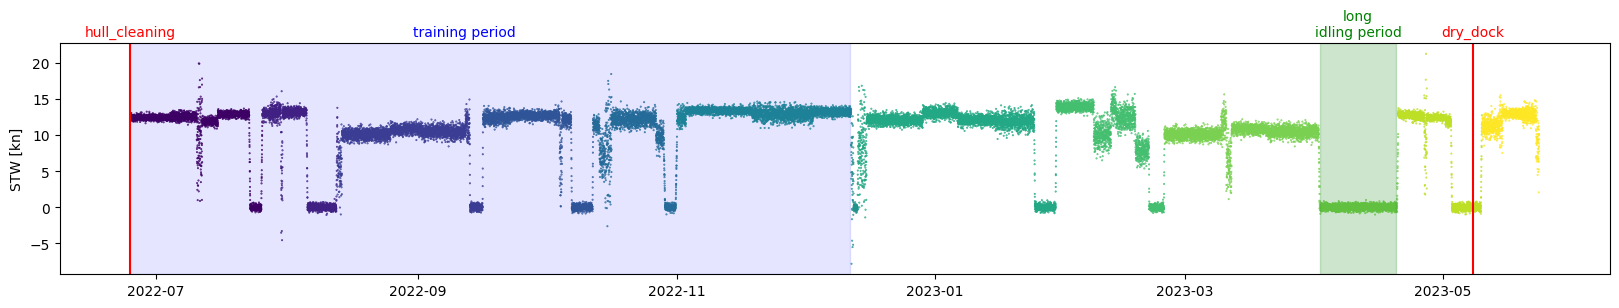

In [101]:
import matplotlib.pyplot as plt
from datetime import datetime

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))
ax.scatter(df["datetime_end"], df["stw"], c=df["voyage"], s=0.2)
ax.set_ylabel("STW [kn]")
for event in df_events.itertuples():
    ax.axvline(event.datetime, color="red")
    ax.text(event.datetime, y=1.03, s=event.type, color="red", transform=ax.get_xaxis_transform(), horizontalalignment='center')
    
ax.axvspan("2023-04-02", "2023-04-20", color="green", alpha=0.2)
ax.text(datetime.strptime("2023-04-11", "%Y-%m-%d"), y=1.03, s="long\nidling period", transform=ax.get_xaxis_transform(), horizontalalignment='center', color='green')

ax.axvspan("2022-06-25", "2022-12-12", color="blue", alpha=0.1)
ax.text(datetime.strptime("2022-09-12", "%Y-%m-%d"), y=1.03, s="training period", transform=ax.get_xaxis_transform(), horizontalalignment='center', color='blue')

On the above graph we see that the ship had a hull cleaning, a dry dock and a long idling period of about 20 days. We also see a period in blue, indicated as "training period". 

The hull cleaning, dry dock and long idling period are events that could alter ship performance. Therefore, our choice for evaluation period will have to be within the period between the hull cleaning and the idling period. However, not all data within that period can be used. The Toqua Ship Kernel is a data-driven model. That means it learns (also called "training") from seen data to predict the outcome on new data. In this case, the period between 2022-06-24 and 2022-12-13 has already been used train the model. As this model has "seen" this data, it would be unfair to evaluate it upon this same data.

Therefore, only the data after the training period, ranging from 2022-12-14 to 2023-04-02 remains, spanning 3 voyages.

Ideally, aim for at least 2 months of data spanning 2 voyages.

In [102]:
period_filters = [
    "datetime_end > '2022-12-14T00:00+00:00'", # keep only data after hull cleaning
    "datetime_end < '2023-04-02T00:00+00:00'"  # keep only data before esd
]

 # apply each filter in turn using .query method
for f in period_filters:
    df = df.query(f)

## 3. Filtering outliers

Outliers are data points that are significantly different from the rest of the data. They can be caused by sensor errors, human errors, or other external factors. We can filters outliers using advanced outlier detection algorithms, or by applying simple thresholds.

In this case, we will apply a set of very simple thresholds. These thresholds filter out data points that are obviously erroneous. 
For example: directions must be between 0 and 360 degrees, fuel consumption cannot be below 0 and sea depth cannot be below 0.

From knowledge of the ship we also know that she can only sail between a draft of 9 and 20m and never uses fuels with an LCV value below 40 MJ/kg.

Be wary that these simple filters definitely do not capture all outliers.

In [103]:
outlier_filters = [
    "stw > 0",
    "me_fo_consumption > 0",
    "fuel_specific_energy > 40",
    "9 < draft_avg < 20",
    "0 < ship_heading < 360",
    "0 < wind_direction < 360",
    "wind_speed > 0",
    "0 < wave_direction < 360",
    "wave_height > 0",
    "0 < current_direction < 360",
    "current_speed > 0",
    "sea_depth > 0",
]

for f in outlier_filters:
    df = df.query(f)

## 4. Filtering unaccounted for external effects

Next, we filter out samples that are affected by external factors which are not accounted for by the model. These are factors the model "has no idea about". In this case, our Ship Kernel takes into acount all parameters of the dataset except sea depth. I.e. sea depth is not an input of the model. However, a shallow sea does result in a perceived decrease in performance due to additional drag. As this effect is not accounted for by the model we will filter out samples with a sea depth below 3 * the draft.

If available, we recommended to also filter out extreme rudder angles or temperatures below 5°C.

In [104]:
external_effect_filters = [
    "sea_depth > 3 * draft_avg"
]

for f in external_effect_filters:
    df = df.query(f)

## 5. Constraining to sea-going conditions

Finally, we remove any conditions during which the vessel is not in normal operation conditions (e.g. during port stay, manoeuvring, etc.).
For this we will use the following filters:
* Speed > 5 kn
* Fuel Consumption > 5 mt/day

In [105]:
sea_condition_filters = [
    "stw > 5",
    "me_fo_consumption > 5",
]

for f in sea_condition_filters:
    df = df.query(f)


Finally the following dataset remains, which meets all the requirements for a correct benchmark dataset.

In [106]:
df.describe()

,voyage,stw,me_fo_consumption,ship_heading,wind_direction,wind_speed,wave_direction,wave_height,current_speed,current_direction,fuel_specific_energy,draft_avg,sea_depth
count,7380.000000,7380.000000,7380.000000,7380.000000,7380.000000,7380.000000,7380.000000,7380.000000,7380.000000,7380.000000,7380.000000,7380.000000,7380.000000
mean,7.950542,11.591255,27.490667,213.511222,132.512553,5.116623,133.422815,0.892056,0.308026,179.731957,41.500007,10.347814,1863.831626
std,0.890612,1.512244,10.030090,32.544375,85.792620,2.226540,69.887014,0.536626,0.198547,77.728715,0.001004,1.353902,1623.300634
min,7.000000,5.049697,5.413080,0.051941,0.685338,0.025311,0.364687,0.000026,0.000064,0.060789,41.496297,9.023718,28.528163
25%,7.000000,10.460494,20.334928,194.559523,57.540746,3.647974,76.589217,0.457470,0.162712,125.441884,41.499326,9.500464,297.351382
50%,8.000000,11.683316,24.825433,216.692597,88.132603,5.006767,127.534646,0.832311,0.274411,179.211400,41.500003,9.799506,1521.068933
75%,9.000000,12.633503,31.749335,228.887073,207.084181,6.338483,181.881403,1.206960,0.416302,235.104390,41.500674,9.801467,3189.077915
max,9.000000,16.248700,76.299553,359.636720,359.923017,16.205710,356.759134,3.054246,1.478095,359.307718,41.503802,13.003581,7307.058820


# 2. Calculate quantitative metrics

To measure how accurate the models are it is important to have meaningful, robust and quantifiable metrics. We will provide an implementation of  the following metrics:
* Mean Absolute Percentage Error (MAPE) 
$$\text{MAPE} = \frac{100}{n} \sum_{i=1}^{n} \left|\frac{\hat{y_i} - y_i}{y_i}\right|$$

* Daily Percentage Error (DPE)
$$\text{DPE} = \frac{100}{D} \sum_{d}^{D} \left| \frac{\sum_{i}^{d} \hat{y}_i - y_{i} }{\sum_{j}^{d} y_{j}} \right|$$


* Voyage Error (VE)
$$\text{VE} = \frac{1}{V} \sum_{v}^{V} \left| \frac{100}{v} \sum_{i}^{v} \frac{ \hat{y}_{i} - y_{i} }{y_i} \right|$$


* Bias Percentage Error (BPE)
$$\text{BPE} = \frac{\sum_{i}^{N} \hat{y}_{i} - \sum_{j}^{N} y_j}{\sum_{k}^{N} y_k}$$

A detailed explanation of these metrics, accompanied by toy examples, may be found in the whitepaper.

In [107]:
import numpy as np

def mape(true, pred):
    """Mean Absolute Percentage Error
    
    true: a list of measured values
    pred: a list of predicted values
    """
    return np.mean(np.abs((pred - true) / true)) * 100

def bpe(true, pred):
    """Bias Percentage Error
    
    true: a list of measured values
    pred: a list of predicted values
    """
    return np.sum(pred - true) / np.sum(true) * 100

def dpe(true, pred, days):
    """Daily Percentage Error
    
    true: a list of measured values
    pred: a list of predicted values
    days: a list of days, corresponding to the day on which the measurement was done
    """
    metrics_per_day = []
    for d in np.unique(days):
        mask = days == d
        metrics_per_day.append(np.abs(bpe(true[mask], pred[mask])))
    return np.mean(metrics_per_day)


def ve(true, pred, voyages):
    """Voyage Error
    
    true: a list of measured values
    pred: a list of predicted values
    voyages: a list of voyage ids, corresponding to the voyage during which the measurement was done
    """
    metrics_per_voyage = []
    for v in np.unique(voyages):
        mask = voyages == v
        metrics_per_voyage.append(np.abs(bpe(true[mask], pred[mask])))
    return np.mean(metrics_per_voyage)

We can use above functions to calculate the metrics, given the ground truth values and the values predicted by the model. The ground truth values we obtain from the benchmark dataset established earlier. 

All that is left is to obtain the predicted values from the Ship Kernel through the Toqua API.

In [108]:
import logging
from time import sleep
from typing import Dict
import pandas as pd
import requests

def make_api_call(method, url, payload=None):
    """Generic function to make an API call to the Toqua API."""
    headers = {
        "accept": "application/json",
        "content-type": "application/json",
        "X-API-Key": API_KEY,
    }
    
    if method == 'GET':
        response = requests.get(url, headers=headers)
    elif method == 'POST':
        response = requests.post(url, json=payload, headers=headers)
    else:
        print("Error: Invalid method")
        return None
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        logging.error(f"Error: {e}")
        logging.error(response.content)
        raise e
    return response.json()


def predict(imo_number, df):
    """Do a prediction on the Toqua Ship Kernel of a given vessel.
    
    This implementation is a bit more complicated than in previous use cases. Because the Toqua API 
    a maximum of 9000 rows at a time  we need to split the data into chunks of 9000.
    """
    url = f"https://api.toqua.ai/ships/{imo_number}/models/latest/predict"
    
    # toqua API limit
    chunk_size = 9000
    # split the input data into chunks of 9000 rows
    chunks = np.array_split(df, len(df) / chunk_size + 1)
    prediction_chunks = []
    # for each chunk, predict the values
    for chunk in chunks:
        model_input = { "data": chunk.drop(columns=["datetime_end", "me_fo_consumption"]).to_dict(orient="list") }
        pred = make_api_call('POST', url, model_input)
        prediction_chunks.append(pd.DataFrame(pred, index=chunk.index))
    # finally, concatenate the results again
    return pd.concat(prediction_chunks)


def calculate_metrics(df):
    """Calculate all metrics from a single dataframe containing the true and predicted values.
    
    The column me_fo_consumption contains the true fuel consumption values, the column predicted_me_fo_consumption contains the predicted values.
    """
    return pd.Series([
        mape(df.me_fo_consumption, df.predicted_me_fo_consumption),
        dpe(df.me_fo_consumption, df.predicted_me_fo_consumption, df.datetime_end.dt.round("1d")),
        ve(df.me_fo_consumption, df.predicted_me_fo_consumption, df.voyage),
        bpe(df.me_fo_consumption, df.predicted_me_fo_consumption)
    ], index= ["Mean Absolute Percentage Error [%]", "Daily Percentage Error [%]", "Voyage Error [%]", "Bias Percentage Error [%]"])

In [109]:
df_predictions = predict(IMO_NUMBER, df)

# add the predictions as new column in the old dataframe for easier comparison
df["predicted_me_fo_consumption"] = df_predictions["me_fo_consumption"]

# show the true values vs the raw predictions
df[["me_fo_consumption", "predicted_me_fo_consumption"]]

,me_fo_consumption,predicted_me_fo_consumption
16520,15.819000,11.407037
16523,8.628153,13.229631
16525,15.405062,8.349540
16526,15.864419,15.017990
16529,17.061974,7.468339
...,...,...
26944,18.703218,18.682173
26945,21.256846,20.354079
26946,24.435409,24.380356
26947,22.557820,21.746785


Finally, we calculate the metrics and print them.

Note that if voyage number is not available in the dataset, the voyage number can be set to the same value everywhere, in that case it will be the same as the BPE.

In [110]:
calculate_metrics(df)

Mean Absolute Percentage Error [%]    9.325074
Daily Percentage Error [%]            4.977160
Voyage Error [%]                      2.583450
Bias Percentage Error [%]             0.373397
dtype: float64

We can see that our Ship Kernel has a MAPE of 9.32%, a DPE of 4.98%, a Voyage Error of 2.58% and a BPE of 0.37%.

As expected, as the MAPE is calculated on the shortest time scale (every 15minutes) it has the highest error. The BPE is calculated on the longest time scale (the entire evaluation period) and thus has the lowest error because the errors cancel each other out. It shows that on average, the model has a bias of 0.37%. The DPE and VE are calculated on intermediate time scales and fall somewhere in between.

The voyage error is an interesting metric to look at more closely. We can examen the errors per voyage seperately so determine whether the model is more accurate on certain voyages than others, indicating that the model is perhaps less performant in specific conditions.

In [112]:
# group the dataframe by voyage and apply the metrics calculation function to each group
df.groupby("voyage").apply(calculate_metrics)

,Mean Absolute Percentage Error [%],Daily Percentage Error [%],Voyage Error [%],Bias Percentage Error [%]
voyage,,,,
7,8.553345,6.814103,3.593704,3.593704
8,14.751815,6.490274,3.601014,-3.601014
9,7.224565,2.347322,0.555632,-0.555632


The voyage error and bias percentage error are the same in this case as the voyage error is simply the mean of the absolute values of the BPE calculated per voyage, but in this case there is only a single voyage. We can see quite some differences between the voyages, demonstrating that the model is not infallible.

All that remains now is seeing how these metrics compare to other models.